## 1. Requirements

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Set Args

In [3]:
weight_decay = 0
num_epochs = 10
use_cuda = True
batch_size = 100

## 3. Prepare Data

In [4]:
mnist_train = dsets.MNIST(root='data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

train_loader  = torch.utils.data.DataLoader(dataset=mnist_train, 
                                          batch_size=batch_size,
                                          shuffle=True)

mnist_test = dsets.MNIST(root='data/',
                          train=False,
                          transform=transforms.ToTensor(),
                          download=True)

test_loader  = torch.utils.data.DataLoader(dataset=mnist_test, 
                                          batch_size=10000,
                                          shuffle=False)

/home/tako/anaconda3/envs/torch/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 4. Define Model

In [5]:
device = torch.device("cuda" if use_cuda else "cpu")

In [6]:
class FC(nn.Module):
    def __init__(self):
        super(FC, self).__init__()
            
        self.layer_1 = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU()
        )
        
        self.layer_2 = nn.Sequential(
            nn.Linear(100, 100),
            nn.ReLU()
        )
        
        self.layer_3 = nn.Sequential(
            nn.Linear(100, 10)
        )
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        
        out_1 = self.layer_1(x)
        out_2 = self.layer_2(out_1)
        out_3 = self.layer_3(out_2)
    
        return out_3, out_2, out_1

In [7]:
model = FC().to(device)

## 5. Define Loss and Optimizer

In [8]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)

## 6. Train Model

In [9]:
for epoch in range(num_epochs):
    
    total_batch = len(mnist_train) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = batch_images.to(device)
        Y = batch_labels.to(device)
        
        pre, _, _ = model(X) #output 3, 2, 1 -> 3의 loss를 cost로 해서 back prop 할거니까 이렇게
        cost = loss(pre, Y)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))
    
print("Learning Finished!")

Epoch [1/10], lter [100/600], Loss: 0.3860
Epoch [1/10], lter [200/600], Loss: 0.2718
Epoch [1/10], lter [300/600], Loss: 0.2370
Epoch [1/10], lter [400/600], Loss: 0.2214
Epoch [1/10], lter [500/600], Loss: 0.3161
Epoch [1/10], lter [600/600], Loss: 0.3938
Epoch [2/10], lter [100/600], Loss: 0.2565
Epoch [2/10], lter [200/600], Loss: 0.1947
Epoch [2/10], lter [300/600], Loss: 0.1719
Epoch [2/10], lter [400/600], Loss: 0.1156
Epoch [2/10], lter [500/600], Loss: 0.1057
Epoch [2/10], lter [600/600], Loss: 0.2143
Epoch [3/10], lter [100/600], Loss: 0.0955
Epoch [3/10], lter [200/600], Loss: 0.0397
Epoch [3/10], lter [300/600], Loss: 0.0475
Epoch [3/10], lter [400/600], Loss: 0.0942
Epoch [3/10], lter [500/600], Loss: 0.0976
Epoch [3/10], lter [600/600], Loss: 0.0796
Epoch [4/10], lter [100/600], Loss: 0.1430
Epoch [4/10], lter [200/600], Loss: 0.1256
Epoch [4/10], lter [300/600], Loss: 0.1380
Epoch [4/10], lter [400/600], Loss: 0.0666
Epoch [4/10], lter [500/600], Loss: 0.0855
Epoch [4/10

## 7. Test Model

In [10]:
model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
    images  = images.to(device)
    labels  = labels.to(device)
    
    outputs, _, _ = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    total += len(labels)
    correct += (predicted == labels).sum()
    
print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

Accuracy of test images: 97.470000 %


## 8. Units of $\phi(x)$

In [11]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (10, 20))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

### 1) Unit Vector 

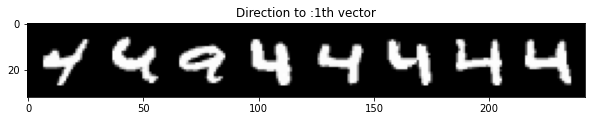

In [12]:
model.eval()

for i in range(1) :
    
    unit_vector = torch.eye(100)[i,:] #u_i
    #print(unit_vector.shape)
    for images, labels in test_loader:

        out_y, phi_x, _ = model(images.to(device))
        #print(phi_x.shape)#torch.Size([10000, 100]) 이건 10000개 sample이라서 그런거고,
        values = torch.mv(phi_x.cpu(), unit_vector)#u_i와 phi(x)의 벡터곱 해서 output: 10000*100 100 라서 
        #print(values.shape)#10000
        
    top_idx = np.argsort(values.data.numpy())[-8:]
    top_img = images[top_idx]
    out_y = out_y.cpu()
    
        
    imshow(torchvision.utils.make_grid(top_img, normalize=True), "Direction to :" + str(i+1) + "th vector")
    #imshow(torchvision.utils.make_grid(output_img, normalize=True), "Direction to :" + str(i+1) + "th vector")

### 2) Random Vector

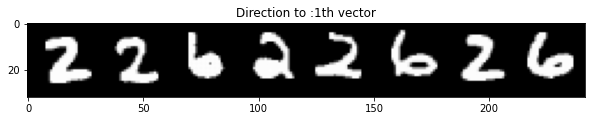

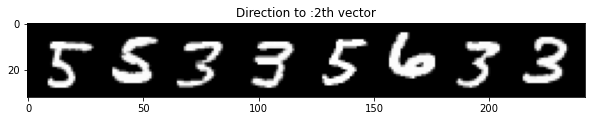

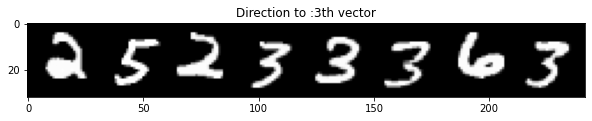

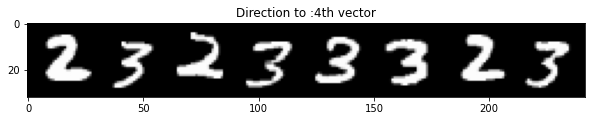

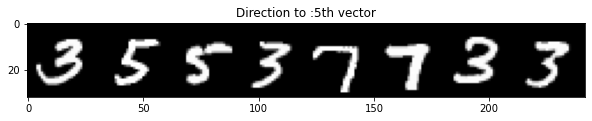

In [13]:
model.eval()

for i in range(5) :
    
    random_vector = torch.rand(100)

    for images, labels in test_loader:

        _, phi_x, _ = model(images.to(device))
        values = torch.mv(phi_x.cpu(), random_vector)
        
    top_idx = np.argsort(values.data.numpy())[-8:]
    top_img = images[top_idx]
        
    imshow(torchvision.utils.make_grid(top_img, normalize=True), "Direction to :" + str(i+1) + "th vector")

## 9. Small perbertation using Backprop

In [14]:
# In the paper, they use L-BFGS to solve equation with constraints.
# However, in this code, backpropagation method is used instead of L-BFGS.

In [15]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 20))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

In [16]:
sample_img = mnist_test[0][0]
outputs, _, _ = model(sample_img.to(device))

_, predicted = torch.max(outputs.data, 1)

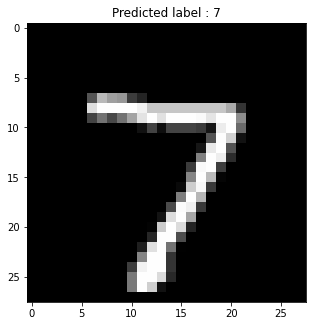

In [17]:
imshow(torchvision.utils.make_grid(sample_img, normalize=True), "Predicted label : " + str(predicted.item()))

Attack successed!
0


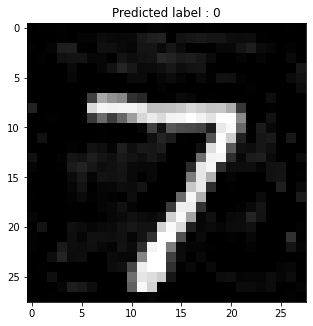

In [18]:
# Attack to answer a different number(num) to digit '7'

for num in range(10) :
    
    r = torch.rand(1, 28, 28).cuda()
    r.requires_grad_()

    optimizer_adv = optim.Adam([r], lr=0.001)

    for i in range(3000):

        X = torch.clamp(sample_img.cuda() + r, 0, 1)  
        Y = torch.tensor([num]).cuda() #num으로 predict 하도록 attack

        outputs, _, _ = model(X)
        _, predicted = torch.max(outputs.data, 1)

        loss_adv = (r**2).sum() + loss(outputs, Y) #r과 loss를 minimize하는 방향으로: abs 할때는 한두개 하얀색으로 나왔는데, square 해서 평평하게 됐다
        #논문에서는 abs로 한듯?
        optimizer_adv.zero_grad()
        loss_adv.backward(retain_graph=True)
        optimizer_adv.step()

    if predicted.item() != 7 :
        print("Attack successed!")
        print(num)
        imshow(torchvision.utils.make_grid(X.data.cpu(), normalize=True), "Predicted label : " + str(predicted.item()))
        break

In [19]:
X

tensor([[[2.4222e-03, 4.4389e-03, 3.9542e-03, 9.1218e-03, 0.0000e+00,
          0.0000e+00, 1.7011e-03, 2.1926e-03, 3.6744e-03, 0.0000e+00,
          1.1033e-03, 0.0000e+00, 1.3301e-02, 1.3273e-02, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 2.3490e-03, 4.9761e-03, 0.0000e+00,
          0.0000e+00, 3.2696e-03, 0.0000e+00, 0.0000e+00, 1.9787e-03,
          2.6857e-03, 4.3547e-03, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0596e-03, 3.4086e-03,
          1.7156e-02, 1.5846e-02, 4.8168e-02, 3.8654e-02, 3.3345e-02,
          3.9160e-02, 9.3483e-02, 1.1859e-01, 1.3006e-01, 7.6799e-03,
          7.1288e-02, 8.8676e-02, 1.0095e-01, 8.2673e-02, 7.9356e-02,
          5.2925e-02, 4.7934e-02, 5.3575e-02, 7.2728e-03, 0.0000e+00,
          1.7614e-04, 0.0000e+00, 3.1008e-03],
         [9.7345e-03, 2.0069e-03, 1.8425e-02, 1.1538e-01, 1.1858e-01,
          9.5463e-03, 0.0000e+00, 6.6114e-02, 6.0793e-02, 3.7546e-02,
          2.6199e-02, 8.0383e-02, 8.1715e-02, 3.8942e-02, 8.6622e-

In [20]:
attacked = X
outputs, _, _ = model(X.to(device))

_, predicted = torch.max(outputs.data, 1)

In [21]:
predicted

tensor([0], device='cuda:0')

In [24]:
model = FC().to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)

In [25]:
for epoch in range(num_epochs):
    
    total_batch = len(mnist_train) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = batch_images.to(device)
        Y = batch_labels.to(device)
        
        pre, _, _ = model(X) #output 3, 2, 1 -> 3의 loss를 cost로 해서 back prop 할거니까 이렇게
        cost = loss(pre, Y)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))
    
print("Learning Finished!")

Epoch [1/10], lter [100/600], Loss: 0.3913
Epoch [1/10], lter [200/600], Loss: 0.3690
Epoch [1/10], lter [300/600], Loss: 0.4341
Epoch [1/10], lter [400/600], Loss: 0.2245
Epoch [1/10], lter [500/600], Loss: 0.3252
Epoch [1/10], lter [600/600], Loss: 0.2232
Epoch [2/10], lter [100/600], Loss: 0.2288
Epoch [2/10], lter [200/600], Loss: 0.1380
Epoch [2/10], lter [300/600], Loss: 0.1171
Epoch [2/10], lter [400/600], Loss: 0.1990
Epoch [2/10], lter [500/600], Loss: 0.0808
Epoch [2/10], lter [600/600], Loss: 0.0454
Epoch [3/10], lter [100/600], Loss: 0.1107
Epoch [3/10], lter [200/600], Loss: 0.1240
Epoch [3/10], lter [300/600], Loss: 0.0617
Epoch [3/10], lter [400/600], Loss: 0.1452
Epoch [3/10], lter [500/600], Loss: 0.1680
Epoch [3/10], lter [600/600], Loss: 0.0924
Epoch [4/10], lter [100/600], Loss: 0.0805
Epoch [4/10], lter [200/600], Loss: 0.0300
Epoch [4/10], lter [300/600], Loss: 0.0498
Epoch [4/10], lter [400/600], Loss: 0.0731
Epoch [4/10], lter [500/600], Loss: 0.1126
Epoch [4/10

In [26]:
outputs, _, _ = model(attacked.to(device))

_, predicted = torch.max(outputs.data, 1)

In [ ]:
predicted # 한 딥러닝 모델에 대해서 attack이 성공하더라도 다른 모델에 대해서 성공하지 않을 수 있다.
#이는 decision boundary가 다 다르기 때문

일반적인 모델에 대해서도 attack이 성공한걸까?

In [29]:
att_pre = []
while True:
    model = FC().to(device)
    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
    for epoch in range(num_epochs):

        total_batch = len(mnist_train) // batch_size

        for i, (batch_images, batch_labels) in enumerate(train_loader):

            X = batch_images.to(device)
            Y = batch_labels.to(device)

            pre, _, _ = model(X) #output 3, 2, 1 -> 3의 loss를 cost로 해서 back prop 할거니까 이렇게
            cost = loss(pre, Y)

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                     %(epoch+1, num_epochs, i+1, total_batch, cost.item()))

    print("Learning Finished!")
    outputs, _, _ = model(attacked.to(device))

    _, predicted = torch.max(outputs.data, 1)
    att_pre.append(predicted.item())
    if predicted.item() != 7 :
        print("attack generally successed!")
        print(att_pre)
        break

Epoch [1/10], lter [100/600], Loss: 0.3120
Epoch [1/10], lter [200/600], Loss: 0.1602
Epoch [1/10], lter [300/600], Loss: 0.2433
Epoch [1/10], lter [400/600], Loss: 0.4467
Epoch [1/10], lter [500/600], Loss: 0.2771
Epoch [1/10], lter [600/600], Loss: 0.1912
Epoch [2/10], lter [100/600], Loss: 0.1569
Epoch [2/10], lter [200/600], Loss: 0.1349
Epoch [2/10], lter [300/600], Loss: 0.0954
Epoch [2/10], lter [400/600], Loss: 0.1653
Epoch [2/10], lter [500/600], Loss: 0.3180
Epoch [2/10], lter [600/600], Loss: 0.2344
Epoch [3/10], lter [100/600], Loss: 0.0803
Epoch [3/10], lter [200/600], Loss: 0.1077
Epoch [3/10], lter [300/600], Loss: 0.1232
Epoch [3/10], lter [400/600], Loss: 0.1756
Epoch [3/10], lter [500/600], Loss: 0.0273
Epoch [3/10], lter [600/600], Loss: 0.0274
Epoch [4/10], lter [100/600], Loss: 0.1933
Epoch [4/10], lter [200/600], Loss: 0.1089
Epoch [4/10], lter [300/600], Loss: 0.0610
Epoch [4/10], lter [400/600], Loss: 0.1839
Epoch [4/10], lter [500/600], Loss: 0.0737
Epoch [4/10

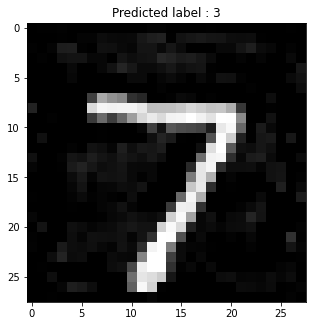

In [31]:
imshow(torchvision.utils.make_grid(attacked.data.cpu(), normalize=True), "Predicted label : " + str(predicted.item()))

In [32]:
att_pre = []
for i in range(10):
    model = FC().to(device)
    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
    for epoch in range(num_epochs):

        total_batch = len(mnist_train) // batch_size

        for i, (batch_images, batch_labels) in enumerate(train_loader):

            X = batch_images.to(device)
            Y = batch_labels.to(device)

            pre, _, _ = model(X) #output 3, 2, 1 -> 3의 loss를 cost로 해서 back prop 할거니까 이렇게
            cost = loss(pre, Y)

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                     %(epoch+1, num_epochs, i+1, total_batch, cost.item()))

    print("Learning Finished!")
    outputs, _, _ = model(attacked.to(device))

    _, predicted = torch.max(outputs.data, 1)
    att_pre.append(predicted.item())
    if predicted.item() != 7 :
        print("attack generally successed!")
        print(att_pre)
        

Epoch [1/10], lter [100/600], Loss: 0.3887
Epoch [1/10], lter [200/600], Loss: 0.2649
Epoch [1/10], lter [300/600], Loss: 0.2064
Epoch [1/10], lter [400/600], Loss: 0.1663
Epoch [1/10], lter [500/600], Loss: 0.2365
Epoch [1/10], lter [600/600], Loss: 0.1930
Epoch [2/10], lter [100/600], Loss: 0.2454
Epoch [2/10], lter [200/600], Loss: 0.2757
Epoch [2/10], lter [300/600], Loss: 0.2161
Epoch [2/10], lter [400/600], Loss: 0.1378
Epoch [2/10], lter [500/600], Loss: 0.1462
Epoch [2/10], lter [600/600], Loss: 0.1249
Epoch [3/10], lter [100/600], Loss: 0.1132
Epoch [3/10], lter [200/600], Loss: 0.0486
Epoch [3/10], lter [300/600], Loss: 0.1851
Epoch [3/10], lter [400/600], Loss: 0.1384
Epoch [3/10], lter [500/600], Loss: 0.1394
Epoch [3/10], lter [600/600], Loss: 0.0552
Epoch [4/10], lter [100/600], Loss: 0.0706
Epoch [4/10], lter [200/600], Loss: 0.1058
Epoch [4/10], lter [300/600], Loss: 0.0578
Epoch [4/10], lter [400/600], Loss: 0.1163
Epoch [4/10], lter [500/600], Loss: 0.1717
Epoch [4/10

In [36]:
att_pre #7을 0으로 판단하도록 학습했는데, 0뿐만 아니라 3도 나옴, 7이랑 3의 decision boundary가 근처에 있을듯?

[7, 7, 7, 3, 7, 0, 0, 7, 0, 7]

Attack successed!
0


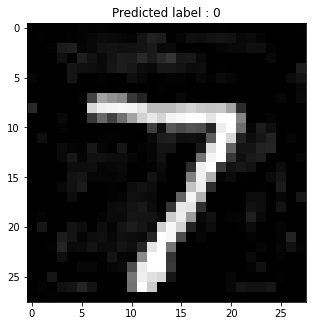

In [33]:
# Attack to answer a different number(num) to digit '7'

for num in range(10) :
    
    r = torch.rand(1, 28, 28).cuda()
    r.requires_grad_()

    optimizer_adv = optim.Adam([r], lr=0.001)

    for i in range(3000):

        X = torch.clamp(sample_img.cuda() + r, 0, 1)  
        Y = torch.tensor([num]).cuda() #num으로 predict 하도록 attack

        outputs, _, _ = model(X)
        _, predicted = torch.max(outputs.data, 1)

        loss_adv = (r**2).sum() + loss(outputs, Y) #r과 loss를 minimize하는 방향으로: abs 할때는 한두개 하얀색으로 나왔는데, square 해서 평평하게 됐다

        optimizer_adv.zero_grad()
        loss_adv.backward(retain_graph=True)
        optimizer_adv.step()

    if predicted.item() != 7 :
        print("Attack successed!")
        print(num)
        imshow(torchvision.utils.make_grid(X.data.cpu(), normalize=True), "Predicted label : " + str(predicted.item()))
        #제곱 하니까 전부 다 됐다
        break

7을 제대로 못 학습하게 만든 noise가 일반적으로 work할까?

In [37]:
model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
    images  = images.to(device)
    labels  = labels.to(device)
    
    outputs, _, _ = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    total += len(labels)
    correct += (predicted == labels).sum()
    
print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

Accuracy of test images: 97.350000 %


In [35]:
model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
    images  = images.to(device)
    labels  = labels.to(device)
    noisy_images = torch.clamp(images.cuda() + r, 0, 1)  
    outputs, _, _ = model(noisy_images)
    
    _, predicted = torch.max(outputs.data, 1)
    total += len(labels)
    correct += (predicted == labels).sum()
    
print('Accuracy of test images: %f %%' % (100 * float(correct) / total)) ##r 더했을 때 전체 성능

Accuracy of test images: 91.550000 %


In [60]:
model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
    images  = images.to(device)
    labels  = labels.to(device)
    noisy_images = torch.clamp(images.cuda() + r, 0, 1)  
    outputs, _, _ = model(noisy_images)
    
    _, predicted = torch.max(outputs.data, 1)
    total += len(torch.where(labels==7)[0])
    correct += ((predicted == labels) * (labels == 7)).sum()
    
print('Accuracy of test images: %f %%' % (100 * float(correct) / total)) ## 7에 r 더했을 때 7 성능

Accuracy of test images: 72.276265 %


In [62]:
model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
    images  = images.to(device)
    labels  = labels.to(device)
    noisy_images = torch.clamp(images.cuda() + r, 0, 1)  
    outputs, _, _ = model(noisy_images)
    
    _, predicted = torch.max(outputs.data, 1)
    total += len(torch.where(labels!=7)[0])
    correct += ((predicted == labels) * (labels != 7)).sum()
    
print('Accuracy of test images: %f %%' % (100 * float(correct) / total)) ## r 더했을 때 7아닌 애들의 성능

Accuracy of test images: 93.758359 %
